# Summary

Here we use PCA on single nucleotide polymorphisms in genetic data from 1000 patients. We then combine the PCA plot with information about the geographic location of the patients and we can see three clusters of points on the principal component plot corresponding to patients from to Asia, Europe and Africa and a third more diffuse group of points corresponding to American patients.

Data taken from: https://www.internationalgenome.org/category/vcf/


# Load modules

In [1]:
import vcf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from vcf file

Here we are loading all of the single nucleotide polymorphisms in chromosome 21 from 1092 pateints who have had their genome sequenced

In [2]:
vcf_file = 'ALL.chr21.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf'
panel_file = 'phase1_integrated_calls.20101123.ALL.panel'

In [3]:
vcf_reader = vcf.Reader(filename=vcf_file)

# Data exploration

The structure of the vcf file is that it has a record for each single nucleotide polymorphism and each record has an entry for each patient. We can then use the get_alleles method to return the genotype for the specific single nucleotide polymorphism  in the specific patient.

The Record shows:

Chromosome number: 21

The position of the single nucleotide polymorphism in the chromsome: Pos=xxxxxxxx

The nucleotide in the reference genome: REF=X

The alternative nucleotide that can be present at this position: ALT=X


The get_alleles function return 4 possible lists:

['0', '0'] : The patient has the reference nucleotide on both maternal and paternal chromosome

['1', '0'] : The patient has the reference nucleotide on one chromosome and the the alternative nucleotide on the other

['0', '1'] : The patient has the reference nucleotide on one chromosome and the the alternative nucleotide on the other

['1', '1'] : The patient has the alternative nucleotide on both maternal and paternal chromosome

In [4]:
counter = 0
for record in vcf_reader:
    for sample in record.samples:
        if counter >= 5:
            break
        counter = counter + 1
        print(f'Record: {record}')
        print(f'patient {str(counter)} id: {record.samples[counter].sample}')
        print(f'Genotype: {record.samples[counter].gt_alleles}')
        print('\n')
    break


Record: Record(CHROM=21, POS=9411243, REF=A, ALT=[C])
patient 1 id: HG00097
Genotype: ['0', '0']


Record: Record(CHROM=21, POS=9411243, REF=A, ALT=[C])
patient 2 id: HG00099
Genotype: ['0', '0']


Record: Record(CHROM=21, POS=9411243, REF=A, ALT=[C])
patient 3 id: HG00100
Genotype: ['0', '0']


Record: Record(CHROM=21, POS=9411243, REF=A, ALT=[C])
patient 4 id: HG00101
Genotype: ['0', '0']


Record: Record(CHROM=21, POS=9411243, REF=A, ALT=[C])
patient 5 id: HG00102
Genotype: ['0', '0']




# Data wrangling

We are going to extract all of the patient IDs into a list

In [5]:
for record in vcf_reader:
    samples = [x.sample for x in record.samples]
    break

print(samples[:5])
print(len(samples))

['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101']
1092


We are now going to pick 1000 single nucleotide polymorphisms from throughout chromosome 21. We are going to store the SNP locations in a list and we are going to extract the genotype for each patient at the position into a list and then append that list into another list so we we end up with a list that contained a list of the genotypes for each patient at each position.



In [6]:
genotypes = []
snp_ids = []
counter = 0
for record in vcf_reader:
    if counter % 100 == 0:

        alleles = [[int(y) for y in x.gt_alleles] for x in record.samples]
        genotypes.append(alleles)
        snp_ids.append(record.POS)
    if counter > 100000:
        break
    counter = counter + 1

In [7]:
print(snp_ids[0:4])

[9411254, 9489234, 9571322, 9661657]


In [8]:
for x in range(5):
    print(genotypes[x][0:4])

[[0, 0], [0, 0], [0, 0], [0, 0]]
[[0, 0], [0, 0], [0, 0], [0, 0]]
[[0, 0], [0, 0], [0, 0], [0, 0]]
[[1, 1], [1, 0], [1, 0], [1, 0]]
[[1, 1], [1, 0], [1, 1], [1, 1]]


In [9]:
genotypes_array = np.array(genotypes)

print(genotypes_array[4][:4])
print(genotypes_array.shape)

[[1 1]
 [1 0]
 [1 1]
 [1 1]]
(1001, 1092, 2)


# Data encoding and restructuring

At the moment we have the genotypes as a list of 2 numbers for each patient at each position and we want this to be 1 number for the PCA model, so  we encode using the following method:

['0', '0'] = 0

['1', '0'] = 1

['0', '1'] = 1

['1', '1'] = 2




In [10]:
matrix = np.count_nonzero(genotypes_array, axis=2)
matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

We transpose the data to format it correctly

In [11]:
matrix_trans = matrix.T
print(matrix[15][:10])
print(matrix.shape)

[0 0 0 0 0 0 0 0 0 0]
(1001, 1092)


# Dataframe

We put our genotype data into a dataframe and then add the genome position as the columns and the patient ID as the row index

In [12]:
df = pd.DataFrame(matrix_trans)
df.columns = snp_ids
df.index = samples
df.head()

,9411254,9489234,9571322,9661657,9774748,9901981,9923904,9938607,9965370,10154118,...,20901189,20905742,20912002,20918474,20923427,20928992,20935270,20940699,20944992,20951266
HG00096,0,0,0,2,2,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00097,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00099,0,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00100,0,0,0,1,2,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00101,0,0,0,1,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Adding geography information

From the supplementary file we find the country and continent info to the dataframe

In [13]:
with open(panel_file) as panel_file_read:
    pop_labels = {}
    for line in panel_file_read:
        line = line.strip().split('\t')
        pop_labels[line[0]] = line[1]

In [14]:
count = 0
for key, value in pop_labels.items():
    print(key, value)
    count += 1
    if count == 5:
        break

HG00096 GBR
HG00097 GBR
HG00099 GBR
HG00100 GBR
HG00101 GBR


In [15]:
df['population_code'] = df.index.map(pop_labels)

In [16]:
with open(panel_file) as panel_file_read:
    continent_labels = {}
    for line in panel_file_read:
        line = line.strip().split('\t')
        continent_labels[line[0]] = line[2]

In [17]:
count = 0
for key, value in continent_labels.items():
    print(key, value)
    count += 1
    if count == 5:
        break

HG00096 EUR
HG00097 EUR
HG00099 EUR
HG00100 EUR
HG00101 EUR


In [18]:
df['continent_code'] = df.index.map(continent_labels)

In [19]:
df.head()

,9411254,9489234,9571322,9661657,9774748,9901981,9923904,9938607,9965370,10154118,...,20912002,20918474,20923427,20928992,20935270,20940699,20944992,20951266,population_code,continent_code
HG00096,0,0,0,2,2,0,2,1,0,0,...,0,0,0,0,0,0,0,0,GBR,EUR
HG00097,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,GBR,EUR
HG00099,0,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,GBR,EUR
HG00100,0,0,0,1,2,0,2,2,0,0,...,0,0,0,0,0,0,0,0,GBR,EUR
HG00101,0,0,0,1,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,GBR,EUR


# Prepare data for PCA model

In [20]:
df_dropped = df.drop(columns=['population_code', 'continent_code'])

In [21]:
df_dropped.head()

,9411254,9489234,9571322,9661657,9774748,9901981,9923904,9938607,9965370,10154118,...,20901189,20905742,20912002,20918474,20923427,20928992,20935270,20940699,20944992,20951266
HG00096,0,0,0,2,2,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00097,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00099,0,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00100,0,0,0,1,2,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00101,0,0,0,1,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Fit PCA model

In [22]:
pca = PCA(n_components=2) 
transformed_data = pca.fit_transform(df_dropped)
pca_df = pd.DataFrame(transformed_data, columns=['PC1', 'PC2'])

In [23]:
pca_df.head()

,PC1,PC2
0,-0.171400,3.207675
1,1.162124,2.635668
2,-1.223346,3.885776
3,-1.274145,1.872760
4,0.575638,3.366727


# Add geographical information back in

In [24]:
pca_df['population_code'] = df.reset_index(drop=True)['population_code']
pca_df['continent_code'] = df.reset_index(drop=True)['continent_code']

In [25]:
pca_df.head()

,PC1,PC2,population_code,continent_code
0,-0.171400,3.207675,GBR,EUR
1,1.162124,2.635668,GBR,EUR
2,-1.223346,3.885776,GBR,EUR
3,-1.274145,1.872760,GBR,EUR
4,0.575638,3.366727,GBR,EUR


In [26]:
pca_df['population_code'].value_counts()

CHS    100
TSI     98
CHB     97
LWK     97
FIN     93
GBR     89
JPT     89
YRI     88
CEU     85
MXL     66
ASW     61
CLM     60
PUR     55
IBS     14
Name: population_code, dtype: int64

In [27]:
pca_df['continent_code'].value_counts()

EUR    379
ASN    286
AFR    246
AMR    181
Name: continent_code, dtype: int64

In [28]:
country_dict =   {'GBR':'British',
                  'CHS':'Han Chinese South',
                  'TSI':'Italians',
                  'CHB':'Han Chinese Beijing',
                  'LWK':'Kenyan',
                  'FIN':'Finnish',
                  'JPT':'Japanese',
                  'YRI':'Nigerian',
                  'CEU':'Utah - European ancestry',
                  'MXL':'Mexican-American',
                  'ASW':'African-American',
                  'CLM':'Colombian',
                  'PUR':'Puerto Rican',
                  'IBS':'Spanish'
                 }


continent_dict = {'EUR':'Europe',
                  'ASN':'Asia',
                  'AFR':'Africa',
                  'AMR':'America',
                 }

In [29]:
pca_df['population_country'] = pca_df['population_code'].map(country_dict)
pca_df['population_continent'] = pca_df['continent_code'].map(continent_dict)

In [30]:
pca_df.head()

,PC1,PC2,population_code,continent_code,population_country,population_continent
0,-0.171400,3.207675,GBR,EUR,British,Europe
1,1.162124,2.635668,GBR,EUR,British,Europe
2,-1.223346,3.885776,GBR,EUR,British,Europe
3,-1.274145,1.872760,GBR,EUR,British,Europe
4,0.575638,3.366727,GBR,EUR,British,Europe


In [31]:
pca_df['population_continent'] = pca_df['continent_code'].map(continent_dict)

In [32]:
pca_df.head()

,PC1,PC2,population_code,continent_code,population_country,population_continent
0,-0.171400,3.207675,GBR,EUR,British,Europe
1,1.162124,2.635668,GBR,EUR,British,Europe
2,-1.223346,3.885776,GBR,EUR,British,Europe
3,-1.274145,1.872760,GBR,EUR,British,Europe
4,0.575638,3.366727,GBR,EUR,British,Europe


# Plot data

In the first plot we colour by country and it i a bit of a mess but on the second plot we colour by continent and the 3 distinct clusters can be seen to represent Asia, Europe and Africa and thirds group of more diffuse points represent America

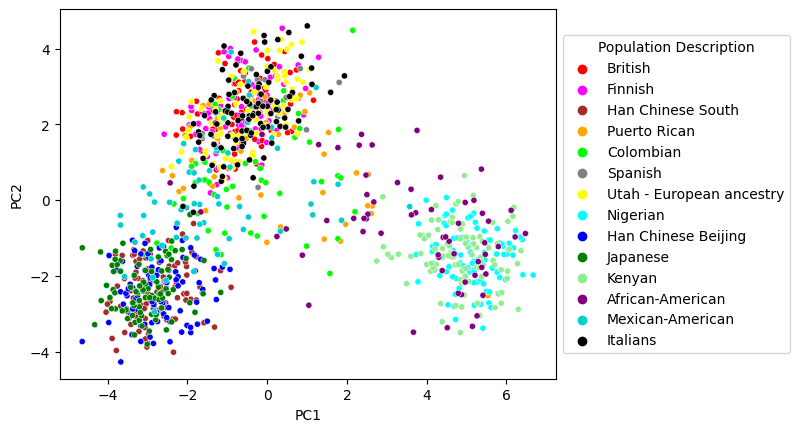

In [33]:

custom_palette = {'British':'red',
                  'Han Chinese South':'brown',
                  'Italians':'black',
                  'Han Chinese Beijing':'blue',
                  'Kenyan':'lightgreen',
                  'Finnish':'magenta',
                  'Japanese':'green',
                  'Nigerian':'cyan',
                  'Utah - European ancestry':'yellow',
                  'Mexican-American':'darkturquoise',
                  'African-American':'purple',
                  'Colombian':'lime',
                  'Puerto Rican':'orange',
                  'Spanish':'gray'
                 }


sns.set_palette(custom_palette.values())

# Create the scatter plot with Seaborn
sns.scatterplot(x='PC1', y='PC2', hue='population_country', data=pca_df, palette=custom_palette,  s=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Population Description')

# Show the plot
plt.show()

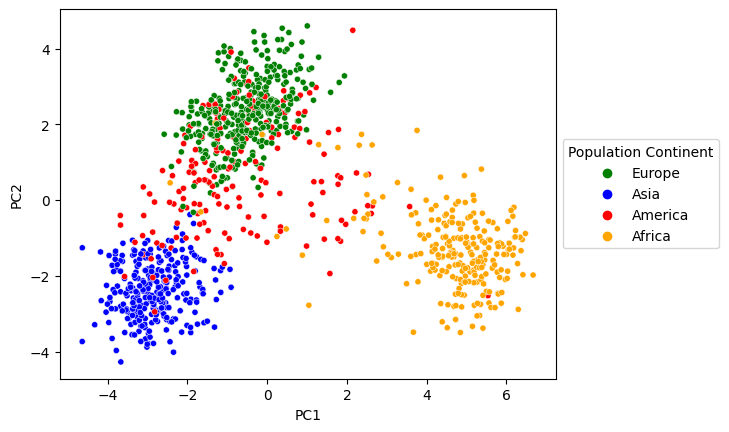

In [34]:

custom_palette = continent_dict = {'Europe':'green',
                                   'Asia':'blue',
                                   'Africa':'orange',
                                   'America':'red',
                                  }


sns.set_palette(custom_palette.values())

# Create the scatter plot with Seaborn
sns.scatterplot(x='PC1', y='PC2', hue='population_continent', data=pca_df, palette=custom_palette,  s=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Population Continent')

# Show the plot
plt.show()